In [1]:
import pickle 
import numpy as np 
import pandas as pd 
import pingouin as pg 
from scipy.special import softmax 

from IPython.display import clear_output
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt 
import seaborn as sns 

import sys
sys.path.append('..')
from utils.fit import fit_bms
from utils.viz import viz 
from utils.model import *
viz.get_style()


In [2]:
method = 'map'    
data_set = 'exp1data'

models = ['MOS6',
          'EU_MO', 'EU_HA', 'MO_HA', 
          'PS_MO_HA', 'linear_comb', 'EU_RD_HA',
          'EU_PS_MO_HA', 'EU_MO_HA_RD',
          'MOS22',
          'EU_MO18', 'EU_HA18', 'MO_HA18', 
          'PS_MO_HA22', 
          'EU_PS_MO_HA26']
tar = models[0]

In [3]:
## get BMS
fit_sub_info = []
for i, m in enumerate(models):
    with open(f'{pth}/fits/{data_set}/fit_sub_info-{m}-{method}.pkl', 'rb')as handle:
        fit_info = pickle.load(handle)
    # get the subject list 
    if i==0: subj_lst = fit_info.keys() 
    # get log post
    log_post = [fit_info[idx]['log_post'] for idx in subj_lst]
    bic      = [fit_info[idx]['bic'] for idx in subj_lst]
    h        = [fit_info[idx]['H'] for idx in subj_lst]
    n_param  = fit_info[list(subj_lst)[0]]['n_param']
    fit_sub_info.append({
        'log_post': log_post, 
        'bic': bic, 
        'n_param': n_param, 
        'H': h,
    })
bms_results = fit_bms(fit_sub_info, use_bic=False)

## get nll, aic ,bic 
cols = ['NLL', 'AIC', 'BIC', 'model', 'sub_id']
crs = {k: [] for k in cols}
for m in models:
    with open(f'../fits/{data_set}/fit_sub_info-{m}-{method}.pkl', 'rb')as handle:
        fit_info = pickle.load(handle)
    # get the subject list 
    if i==0: subj_lst = fit_info.keys() 
    # get log post
    nll = [-fit_info[idx]['log_like'] for idx in subj_lst]
    aic = [fit_info[idx]['aic'] for idx in subj_lst]
    bic = [fit_info[idx]['bic'] for idx in subj_lst]
    bic = [fit_info[idx]['bic'] for idx in subj_lst]
    crs['NLL'] += nll
    crs['AIC'] += aic
    crs['BIC'] += bic
    crs['model'] += [m]*len(nll)
    crs['sub_id'] += list(subj_lst)
#crs['PXP'] = bms_results['pxp']
crs = pd.DataFrame.from_dict(crs)
for c in ['NLL', 'BIC', 'AIC']:
    tar_crs = len(models)*list(crs.query(f'model=="{tar}"')[c].values)
    crs[c] -= tar_crs
pxp = pd.DataFrame.from_dict({'pxp': bms_results['pxp'], 'model': models})

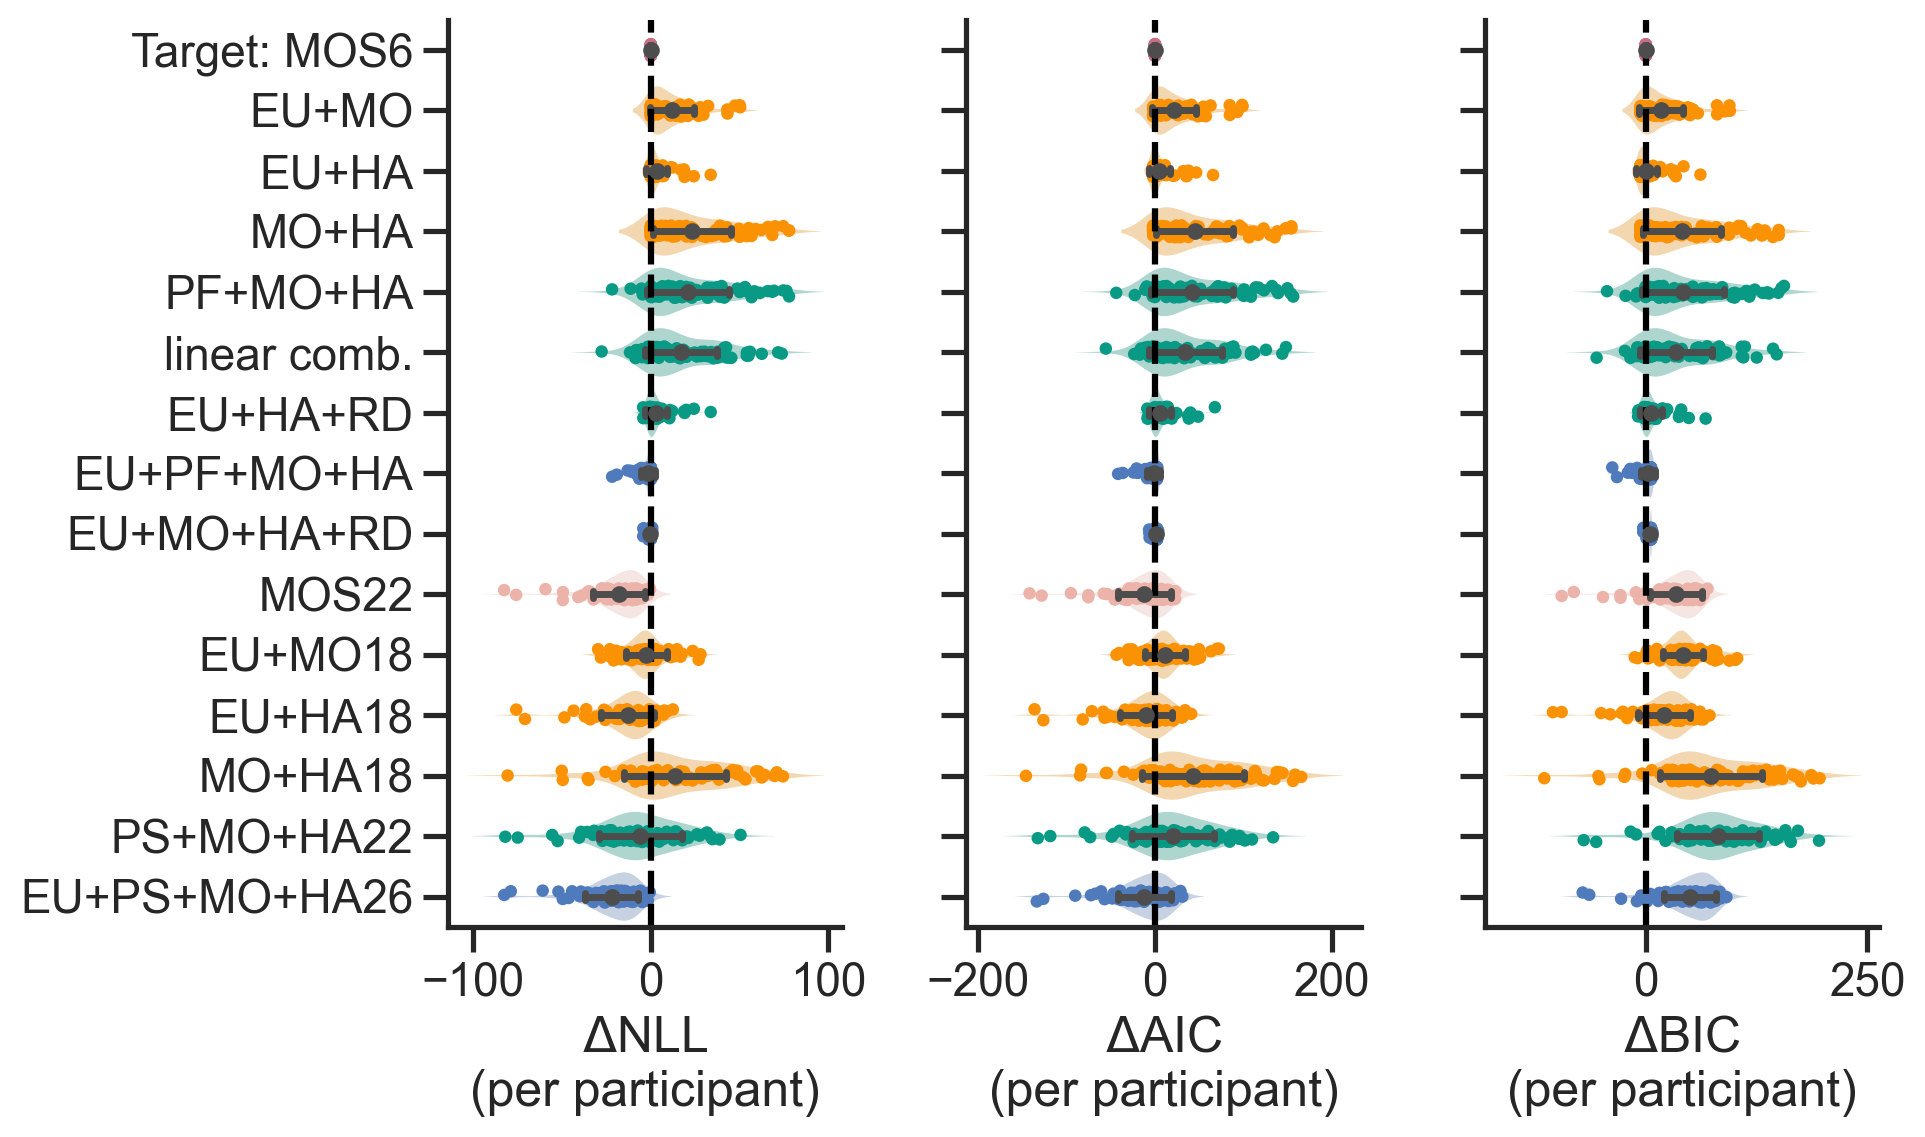

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(10, 6))
for fi, x_var in enumerate(['NLL', 'AIC', 'BIC']):
        ax = axs[fi]
        #x_var = 'BIC'
        tar   = 'model'
        sel_data = crs
        palette = [eval(m).color for m in models]
        viz.violin(ax, data=sel_data, y=tar,
                   x=x_var, order=models, orient='h',
                   palette=palette, scatter_size=4.5,
                   errorbar='sd')
        ax.axvline(x=0, ymin=0, ymax=1, color='k', ls='--')
        lbl = [eval(m).name for m in models]
        lbl.pop(0)
        lbl.insert(0, 'Target: MOS6')
        ax.set_yticks(list(range(len(models))))
        ax.set_yticklabels(lbl) if fi==0 else ax.set_yticklabels('')
        ax.set_xlabel(r'$\Delta$'+f'{x_var}\n(per participant)')
        ax.set_ylabel('')
        ax.set_box_aspect(2.3)
fig.tight_layout()
plt.savefig(f'../figures/FigS1_all_model_comp.pdf', dpi=300)